<a href="https://colab.research.google.com/github/SeoulTechPSE/fenicsx-colab/blob/main/02_convergence_test_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --------------------------------------------------
# 1️⃣ Mount Google Drive (optional, for cache)
# --------------------------------------------------
from google.colab import drive
import os

if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")
else:
    print("📦 Google Drive already mounted")

# --------------------------------------------------
# 2️⃣ Clone fenicsx-colab repository (idempotent)
# --------------------------------------------------
from pathlib import Path
import subprocess

REPO_URL = "https://github.com/seoultechpse/fenicsx-colab.git"
ROOT = Path("/content")
REPO_DIR = ROOT / "fenicsx-colab"

def run(cmd):
    #print("$", " ".join(map(str, cmd)))
    subprocess.run(cmd, check=True)

if not REPO_DIR.exists():
    print("📥 Cloning fenicsx-colab...")
    run(["git", "clone", REPO_URL, str(REPO_DIR)])
elif not (REPO_DIR / ".git").exists():
    raise RuntimeError("Directory exists but is not a git repository")
else:
    print("📦 Repository already exists — skipping clone")

# --------------------------------------------------
# 3️⃣ Run setup_fenicsx.py IN THIS KERNEL (CRITICAL)
# --------------------------------------------------
print("🚀 Running setup_fenicsx.py in current kernel")

USE_CLEAN = False  # <--- Set True to remove existing environment
opts = "--clean" if USE_CLEAN else ""

get_ipython().run_line_magic(
    "run", f"{REPO_DIR / 'setup_fenicsx.py'} {opts}"
)

# ==================================================
# 4️⃣ Sanity check
# ==================================================
try:
    get_ipython().run_cell_magic('fenicsx', '--info -np 4', '')
except Exception as e:
    print("⚠️ %%fenicsx magic not found:", e)

Mounted at /content/drive
📥 Cloning fenicsx-colab...
🚀 Running setup_fenicsx.py in current kernel
📦 Google Drive detected — using persistent cache
🔧 Installing FEniCSx environment...
✨ Loading FEniCSx Jupyter magic... %%fenicsx registered

🐍 Python          : 3.11.14
📦 dolfinx         : 0.10.0
💻 Platform        : Linux-6.6.105+-x86_64-with-glibc2.35
🧵 Running as root : True

🔎 fenicsx runtime info
-----------------------
Environment        : fenicsx
micromamba         : /content/micromamba/bin/micromamba
MPI implementation : OPENMPI
MPI version        : mpiexec (OpenRTE) 4.1.2
MPI ranks (-np)    : 4


---

## 📈 Convergence Order (L2-norm)

To assess the accuracy of the finite element approximation, we study the **convergence order** of the numerical solution in the $L^2$ norm.

For the Poisson problem on a unit square, let $u$ be the exact solution and $u_h$ the finite element solution on a mesh with characteristic size $h$.  
The $L^2$ error is defined as

$$
\| u - u_h \|_{L^2(\Omega)}
=
\left(
\int_\Omega (u - u_h)^2 \, dx
\right)^{1/2}.
$$

---

### Expected theoretical convergence rates

For Lagrange finite elements of degree $p$ on a quasi-uniform mesh, the theoretical convergence rate in the $L^2$ norm is

$$
\| u - u_h \|_{L^2(\Omega)} = \operatorname{O} (h^{p+1}).
$$

In two dimensions, since the mesh size satisfies $h \sim 1/N$ (where $N$ is the number of elements per direction), this can be written as

$$
\| u - u_h \|_{L^2(\Omega)} \approx C \, N^{-(p+1)}.
$$

Therefore, we expect:
- **P1 (linear elements)**: second-order convergence  
- **P2 (quadratic elements)**: third-order convergence  
- **P3 (cubic elements)**: fourth-order convergence  

---

### Numerical estimation of the convergence order

To estimate the convergence order numerically, we compute the slope of the curve in a log–log plot:

$$
\log(\text{error}) = -r \, \log(N) + C,
$$

where $r$ is the **observed convergence order**.

The slope is obtained via a linear least-squares fit of  
$\log(\text{error})$ versus $\log(N)$.

A straight line with slope $r \approx p+1$ confirms optimal convergence.

In [2]:
%%fenicsx -np 1 --time

import numpy as np
from mpi4py import MPI

import matplotlib.pyplot as plt

from dolfinx import mesh, fem
from dolfinx.fem.petsc import LinearProblem

import ufl

comm = MPI.COMM_WORLD
rank = comm.rank

# -----------------------------------------------------------
# Parameters
# -----------------------------------------------------------
mesh_sizes = [8, 16, 32, 64]      # Convergence meshes
element_degrees = [1, 2, 3]       # P1, P2, P3

errors_L2 = np.zeros((len(mesh_sizes), len(element_degrees)))

# -----------------------------------------------------------
# Loop over mesh sizes and element degrees
# -----------------------------------------------------------
for i, N in enumerate(mesh_sizes):
    domain = mesh.create_unit_square(comm, N, N)

    x = ufl.SpatialCoordinate(domain)

    # Exact solution and RHS
    u_exact = ufl.sin(np.pi *x[0]) *ufl.sin(np.pi *x[1])
    f = 2.0 *np.pi**2 *u_exact

    for j, deg in enumerate(element_degrees):
        V = fem.functionspace(domain, ("CG", deg))

        # Dirichlet BC
        u_D = fem.Function(V)
        u_D.interpolate(lambda x: np.zeros(x.shape[1]))
        fdim = domain.topology.dim -1
        boundary_facets = mesh.locate_entities_boundary(
            domain, fdim, lambda x: np.full(x.shape[1], True)
        )
        bc = fem.dirichletbc(
            u_D, fem.locate_dofs_topological(V, fdim, boundary_facets)
        )

        # Variational problem
        u = ufl.TrialFunction(V)
        v = ufl.TestFunction(V)

        a = ufl.inner(ufl.grad(u), ufl.grad(v)) *ufl.dx
        L = f *v *ufl.dx

        problem = LinearProblem(
            a, L, bcs=[bc],
            petsc_options={
                "ksp_type": "cg",
                "pc_type": "hypre",
                "ksp_rtol": 1e-10,
                "ksp_atol": 1e-12
            },
            petsc_options_prefix="poisson_"
        )
        uh = problem.solve()

        # L2 error
        error_form = ufl.inner(uh -u_exact, uh -u_exact) *ufl.dx
        local_L2 = fem.assemble_scalar(fem.form(error_form))
        L2_error = np.sqrt(comm.allreduce(local_L2, op=MPI.SUM))
        errors_L2[i, j] = L2_error

# -----------------------------------------------------------
# Plot convergence (rank 0 only)
# -----------------------------------------------------------
if rank == 0:

    print("\nL2 error table:")
    print("N      P1        P2        P3")
    print("-"*35)

    for i, N in enumerate(mesh_sizes):
        vals = "  ".join(f"{errors_L2[i,j]:.2e}" for j in range(len(element_degrees)))
        print(f"{N:<6} {vals}")

    print()

    # -----------------------------------------------------------

    convergence_rates = []

    for j, deg in enumerate(element_degrees):
        # log-log linear fit
        coeffs = np.polyfit(
            np.log(mesh_sizes),
            np.log(errors_L2[:, j]),
            1
        )
        rate = -coeffs[0]
        convergence_rates.append(rate)

        print(f"P{deg} convergence rate ≈ {rate:.2f}")

    print()

    # -----------------------------------------------------------

    plt.figure(figsize=(6, 4))

    for j, deg in enumerate(element_degrees):
        plt.loglog(
            mesh_sizes,
            errors_L2[:, j],
            marker='o',
            label=f"P{deg} (rate ≈ {convergence_rates[j]:.2f} )")

    plt.xlabel("Mesh size N")
    plt.ylabel("L2 error")
    plt.title("Poisson 2D Convergence Test")

    plt.xticks(mesh_sizes, [str(N) for N in mesh_sizes])
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())
    plt.gca().xaxis.set_major_locator(plt.FixedLocator(mesh_sizes))

    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()

    plt.savefig("convergence_poisson_2d.png", dpi=300)
    plt.close()


L2 error table:
N      P1        P2        P3
-----------------------------------
8      2.11e-02  5.48e-04  2.00e-05
16     5.38e-03  6.87e-05  1.22e-06
32     1.35e-03  8.60e-06  7.50e-08
64     3.38e-04  1.08e-06  4.66e-09

P1 convergence rate ≈ 1.99
P2 convergence rate ≈ 3.00
P3 convergence rate ≈ 4.02

⏱ Elapsed time: 7.303965 s


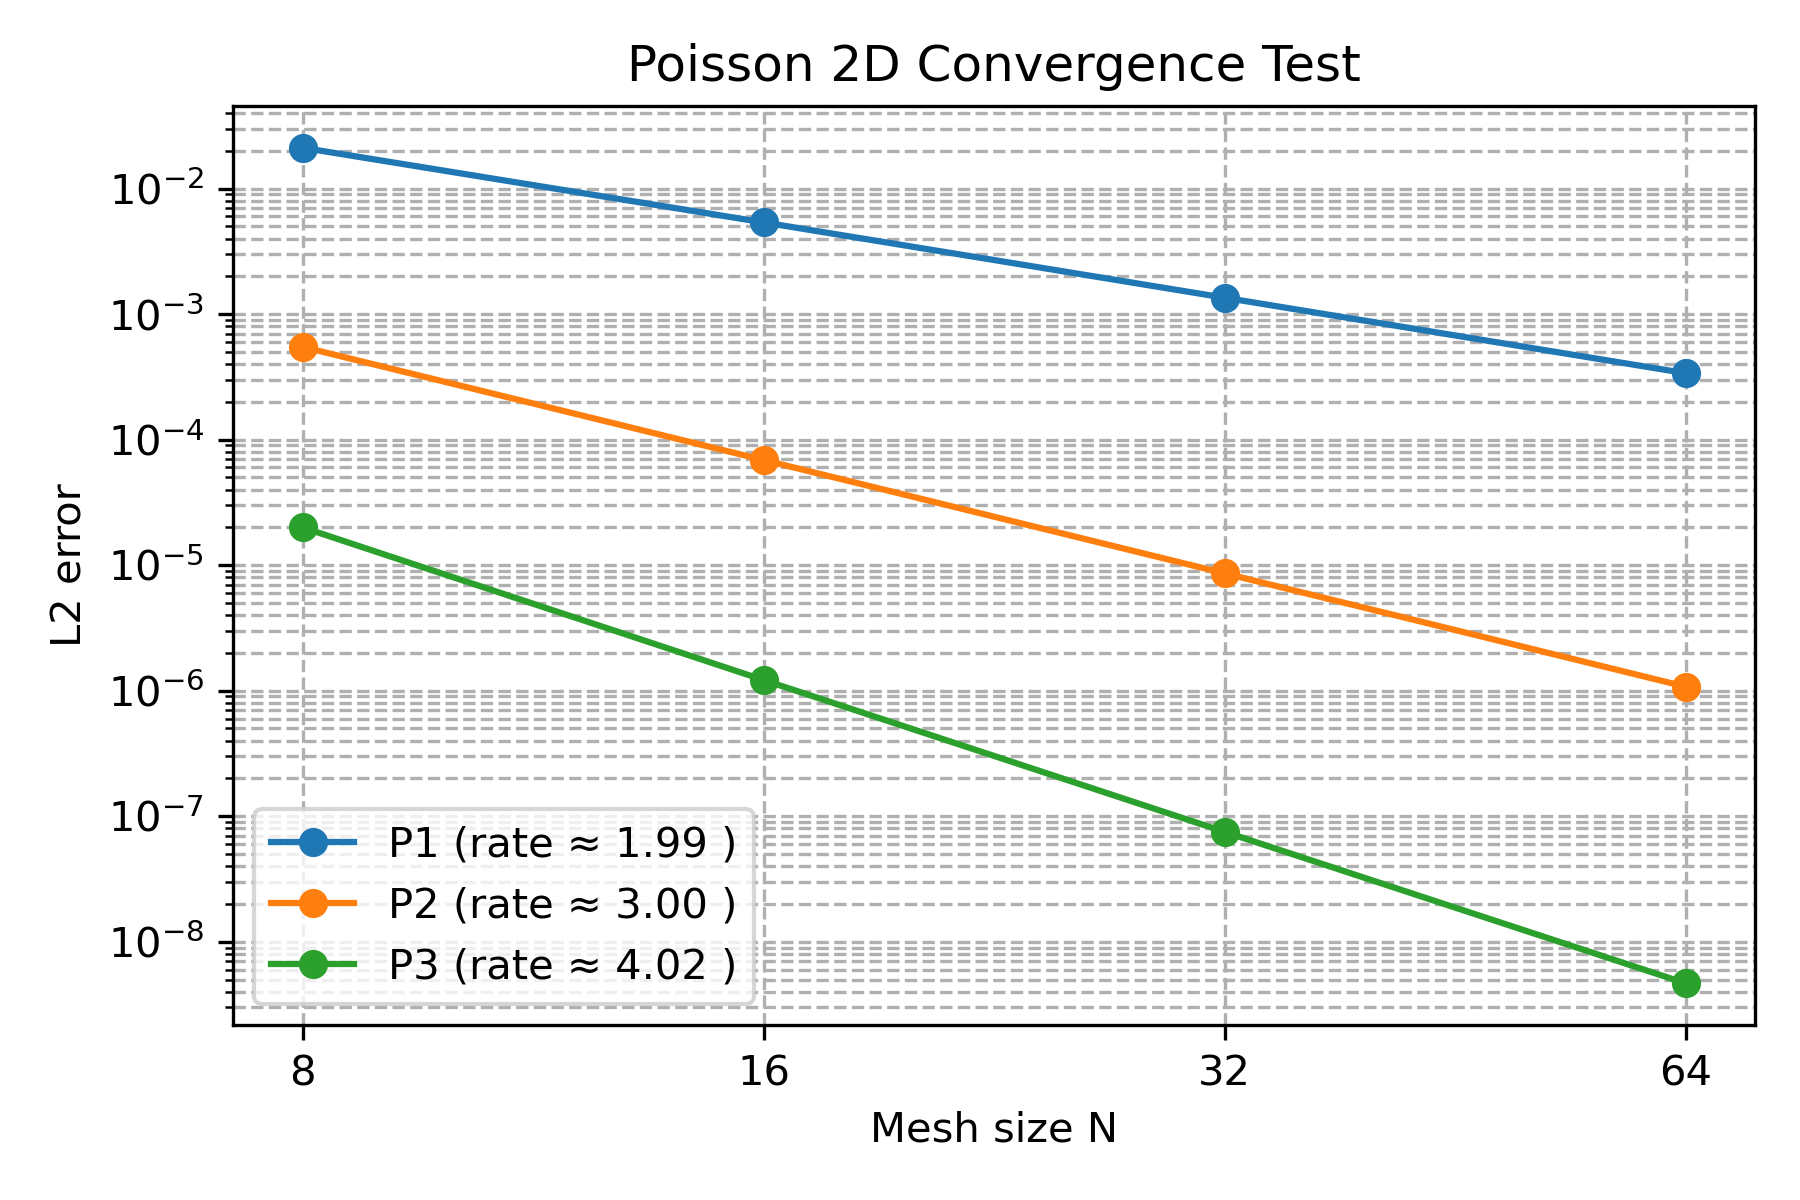

In [3]:
from IPython.display import Image, display

display(Image("convergence_poisson_2d.png"))